In [1]:
#Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Read in data

plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
games = pd.read_csv('games.csv')
pff = pd.read_csv('pffScoutingData.csv')

week_count = 1
weekly = pd.DataFrame()

for dirname, _, filenames in os.walk('/Users/arjun/Desktop/nfl-big-data-bowl-2023'):
    for filename in filenames:
        if 'week' in filename:
            path = os.path.join(dirname, filename)
            temp_week = pd.read_csv(path)
            temp_week['week'] = week_count
            weekly = pd.concat([temp_week, weekly])
            week_count +=1

In [4]:
# Turn time into datetime format, create a 'second' column so that we can calculate the difference between 
# the time the ball was snapped and thrown (time to throw)

weekly['second_whole'] = pd.to_datetime(weekly['time']).dt.second
weekly['microsecond'] = pd.to_datetime(weekly['time']).dt.microsecond
weekly['second'] = weekly['second_whole'] + (weekly['microsecond'] / 1000000)

In [5]:
# Removes the literal football tracking data

weekly_clean = weekly.dropna()

In [6]:
ids = weekly_clean.gameId

In [7]:
# Split df into 2, one for ball snap one for ball release

ball_snap = weekly_clean[weekly_clean.event == 'ball_snap']
release = weekly_clean[weekly_clean.event == 'pass_forward']

In [8]:
# Time the ball was snapped and thrown for each play in each game 

ball_snap_clean = ball_snap.groupby(['gameId', 'playId'], as_index = False).agg({
    'team':'first',
    'second':'first'
})

release_clean = release.groupby(['gameId', 'playId'], as_index = False).agg({
    'team':'first',
    'second':'first'
})

In [9]:
# Merge dataframes, calculate 'time to throw'

ttt_df = ball_snap_clean.merge(release_clean, on = ['gameId', 'playId', 'team'], suffixes = ['_snap', '_release'])
ttt_df['ttt'] = ttt_df['second_release'] - ttt_df['second_snap']
ttt_df['ttt'].mask(ttt_df['ttt'] < 0, 60 + (ttt_df['ttt']), inplace = True)

In [10]:
weekly_clean = weekly_clean.merge(ttt_df[['gameId', 'playId', 'ttt']], on = ['gameId', 'playId'])

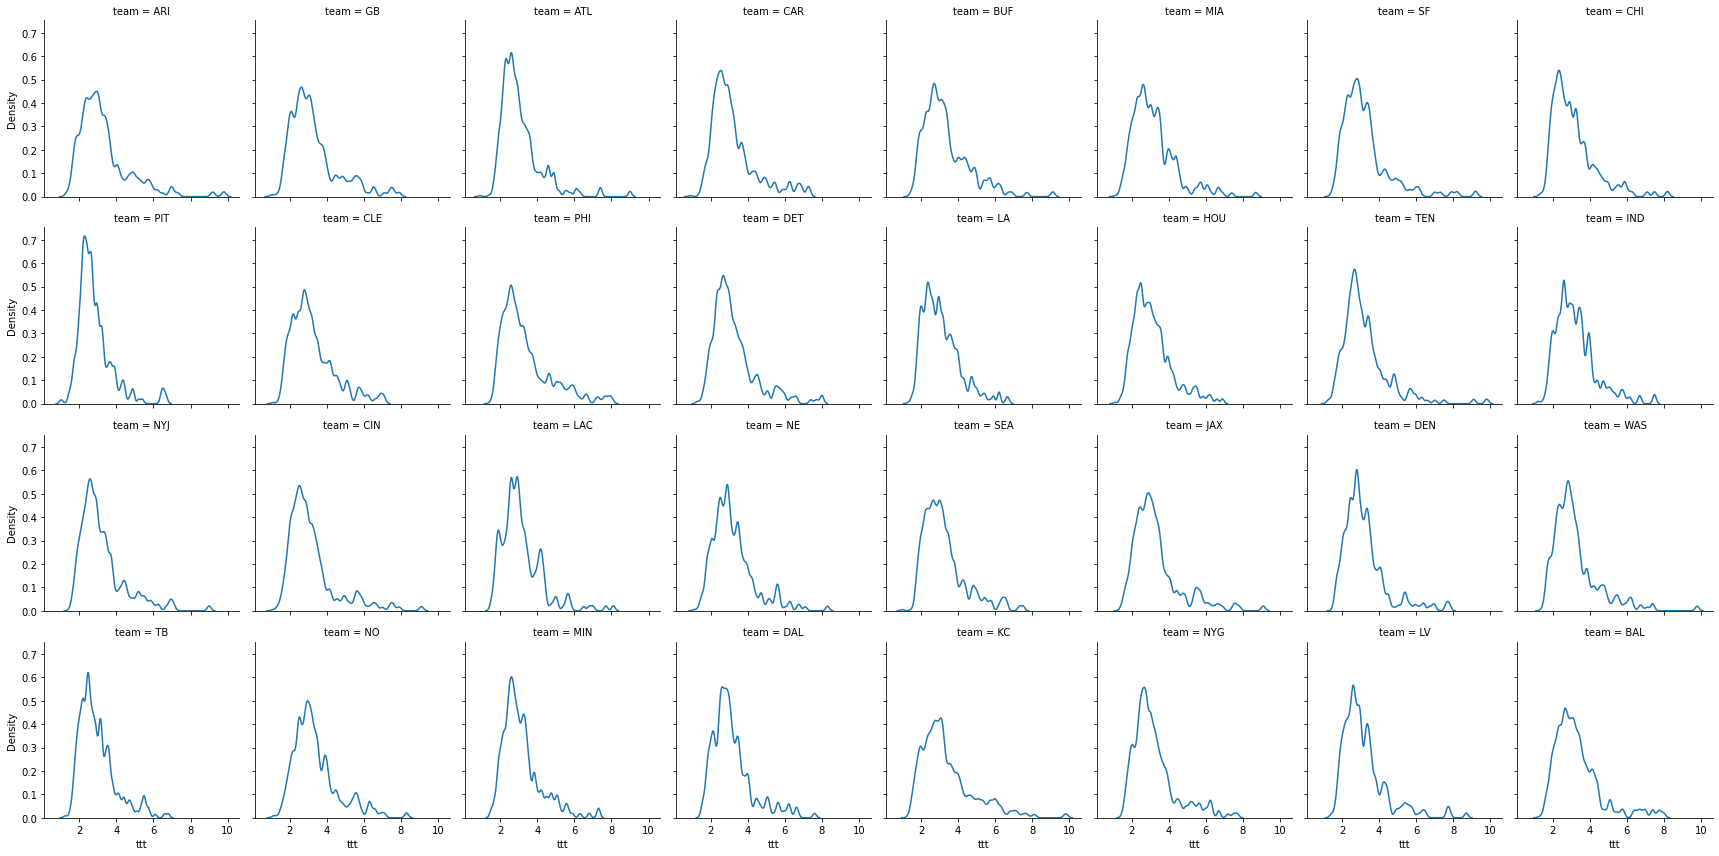

In [11]:
# Density of the time to throw for each QB, just to see

g = sns.FacetGrid(weekly_clean[['ttt', 'team']], col='team', col_wrap=8)
g.map(sns.kdeplot, 'ttt')
plt.show()

In [12]:
full = ttt_df[['gameId', 'playId', 'ttt']].merge(plays, on = ['gameId', 'playId'])
full = full[(full.offenseFormation.notna()) & (full.offenseFormation != 'WILDCAT')]

In [13]:
pff_clean = pff[pff.pff_hit.notna()]
pff_full = pff_clean = pff_clean.merge(ttt_df[['gameId', 'playId', 'ttt']], on = ['gameId', 'playId'])

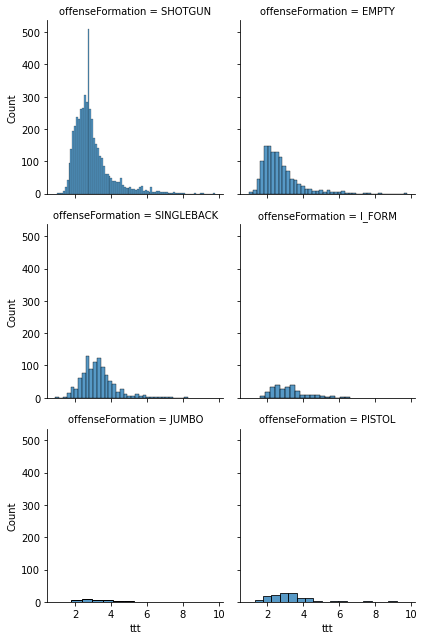

In [14]:
g2 = sns.FacetGrid(full[['ttt', 'offenseFormation']], col='offenseFormation', col_wrap=2)
g2.map(sns.histplot, 'ttt')

In [15]:
full['down'] = full['down'].astype('category')
full['offenseFormation'] = full['offenseFormation'].astype('category')
pbp = pd.get_dummies(full, columns=['down', 'offenseFormation'])

In [16]:
import nfl_data_py as nfl

nfl_pbp = nfl.import_pbp_data([2021])

2021 done.
Downcasting floats.


In [17]:
nfl_pbp = nfl_pbp[nfl_pbp.week <= 8]
nfl_pbp = nfl_pbp.rename(columns={'old_game_id':'gameId', 'play_id':'playId'})

In [18]:
nfl_pbp['gameId'] = nfl_pbp['gameId'].astype('int64')
nfl_pbp['gameId'] = nfl_pbp['gameId'].astype('int64')

In [19]:
df = nfl_pbp[['xpass', 'number_of_pass_rushers', 'gameId', 'playId']].merge(plays, on = ['gameId', 'playId'])
df = df.merge(pbp[['gameId', 'playId', 'ttt', \
                  'down_1', 'down_2', 'down_3', 'down_4', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', \
                  'offenseFormation_JUMBO', 'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', \
                  'offenseFormation_SINGLEBACK']], on = ['gameId', 'playId'])

In [20]:
df = df[(df.number_of_pass_rushers.notna()) & 
        (df.xpass.notna())]

features = df[['xpass', 'number_of_pass_rushers', 'absoluteYardlineNumber', 'defendersInBox','down_1', 'down_2', \
            'down_3', 'down_4', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', \
            'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK']]

target = df['ttt']



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=50)

In [23]:
LR = LinearRegression()
LR.fit(X_train, y_train)
LR_pred = pd.DataFrame(LR.predict(X_test), columns = ['lr_ttt'])

In [24]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

RF_pred = pd.DataFrame(RF.predict(X_test), columns = ['rf_ttt'])

In [25]:
XGB = XGBRegressor(objective="reg:linear", random_state=4)
XGB.fit(X_train, y_train)

XGB_pred = pd.DataFrame(XGB.predict(X_test), columns = ['xgb_ttt'])

[16:06:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


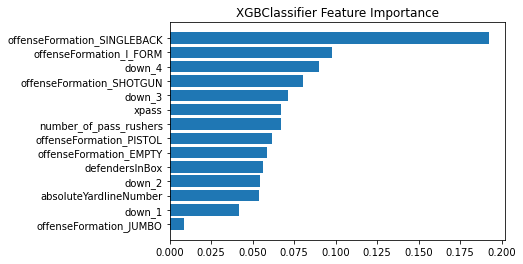

In [26]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance")
plt.show()

In [27]:
pff_clean = pff[(pff.pff_hit.notna()) & (pff.pff_role == 'Pass Rush')]
pff_clean = pff_clean.merge(players[['displayName', 'nflId']], on = 'nflId')
pff_no_sacks = pff_clean[
    (pff_clean.pff_hit == 1) |
    (pff_clean.pff_hurry == 1)
]

In [28]:
ttt_preds = df.drop(columns = 'ttt')

xgb_total_preds = pd.DataFrame(XGB.predict(ttt_preds[['xpass', 'number_of_pass_rushers', 'absoluteYardlineNumber', 'defendersInBox','down_1', 'down_2', \
            'down_3', 'down_4', 'offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', \
            'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK']]), columns = ['xgb_ttt_pred'])

final_ttt_preds = df.reset_index().drop(columns = 'index')
final_ttt_preds['exp_ttt'] = xgb_total_preds

In [31]:
complete_df = final_ttt_preds.merge(pff_clean[['gameId', 'playId', 'nflId', 'displayName']], on = ['gameId', 'playId'])
complete_df['ttt_ue'] = complete_df['ttt'] - complete_df['exp_ttt']


ttt_ue_df = complete_df.groupby(['displayName']).agg({'ttt_ue':'sum', 'xpass':'count', 'defensiveTeam':'first'}).sort_values('ttt_ue')

# ttt_ue_df['ttt_ue/play'] = ttt_ue_df['ttt_ue'] / ttt_ue_df['xpass']


ttt_ue_df.reset_index().drop(columns='xpass').sort_values('ttt_ue').style.background_gradient(cmap="Blues").set_table_attributes("style='display:inline'") \
.set_caption('Leaders in Time to Throw Under Expected (2021 Weeks 1-8)')


,displayName,ttt_ue,defensiveTeam
0,Fletcher Cox,-21.417149,PHI
1,Aaron Donald,-20.645356,LA
2,Josh Sweat,-18.846879,PHI
3,John Franklin-Myers,-18.235484,NYJ
4,Derek Barnett,-17.422683,PHI
5,Terrell Lewis,-17.258849,LA
6,Chase Young,-16.968979,WAS
7,Yannick Ngakoue,-15.892634,LV
8,Daron Payne,-15.811801,WAS
9,Cameron Heyward,-15.631159,PIT


In [30]:
qb_names = pff[pff.pff_positionLinedUp == 'QB'].merge(players[['displayName', 'nflId']], on = 'nflId')[['displayName', 'gameId', 'nflId', 'playId']]

qb_complete = final_ttt_preds.merge(qb_names, on = ['gameId', 'playId'])
qb_complete['ttt_oe'] = qb_complete['ttt'] - qb_complete['exp_ttt']

qb_ttt_ue = qb_complete.groupby(['displayName']).agg({'ttt_oe':'sum'}).sort_values('ttt_oe', ascending=False)

# qb_ttt_ue.reset_index().sort_values('ttt_oe', ascending=False).style.background_gradient(cmap="Blues").set_table_attributes("style='display:inline'") \
# .set_caption('Leaders in Time to Throw Over Expected (2021 Weeks 1-8)')
